In [1]:
import os

GDRIVE_PATH = r"G:\.shortcut-targets-by-id\1beGdS9sPeQXTJvuA20Xc7LIb--s7Ms3u\genome_analysis\data_gdc"

print("Files in Google Drive Folder:", os.listdir(GDRIVE_PATH))


Files in Google Drive Folder: ['GDC-PANCAN.basic_phenotype.tsv', 'GDC-PANCAN.htseq_fpkm.tsv', 'Homo_sapiens.GRCh38.104.gtf', 'Homo_sapiens.GRCh38.113.gtf', 'pancan_htseg_fpkm_yfiltered.parquet']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
targets = pd.read_csv(GDRIVE_PATH + '/GDC-PANCAN.basic_phenotype.tsv',sep='\t')
targets["project_id"] = targets["project_id"].str.replace("TCGA-", "", regex=True)

In [5]:
data = pd.read_parquet('D:/pancan_htseg_fpkm_yfiltered.parquet', engine='pyarrow')

In [6]:
for col in data.columns.drop('Ensembl_ID'):
    data[col] = data[col].astype(np.float16)

In [7]:
row_mask = (data.iloc[:, 1:].sum(axis=1, numeric_only=True) > 0)
data = data.loc[row_mask]
del row_mask

In [8]:
missing_percentage = data.iloc[:, 1:].isna().mean(axis=1)

data = data[missing_percentage <= 0.10]

In [16]:
def get_chromosome_mapping(file_path):
    chromosome_map = {}

    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#"):
                continue

            fields = line.strip().split("\t")
            if fields[2] != "gene":
                continue

            chromosome = fields[0]
            attributes = fields[8]

            gene_id = attributes.split('gene_id "')[1].split('"')[0]

            chromosome_map[gene_id] = chromosome

    return chromosome_map

gtf_chr_map_104 = get_chromosome_mapping(GDRIVE_PATH + '/Homo_sapiens.GRCh38.104.gtf')
gtf_chr_map_113 = get_chromosome_mapping(GDRIVE_PATH + '/Homo_sapiens.GRCh38.113.gtf')

In [17]:
data["Ensembl_ID"] = data["Ensembl_ID"].apply(lambda x: x.split(".")[0])

data["chromosome"] = data["Ensembl_ID"].apply(lambda x: gtf_chr_map_104.get(x, gtf_chr_map_113.get(x, "Unknown")))

data = data[~data["chromosome"].isin(["Y", "Unknown", "MT"])]

In [13]:
del gtf_chr_map_104
del gtf_chr_map_113

In [18]:
data = data.drop(columns=["chromosome"], errors="ignore")

In [19]:
data.iloc[:, 1:] = np.log2(data.iloc[:, 1:] + 1)

In [16]:
#skip this step and scale later (but perhaps can do it here - later considerations)
data.iloc[:, 1:] = (data.iloc[:, 1:] - data.iloc[:, 1:].min().min()) / (data.iloc[:, 1:].max().max() - data.iloc[:, 1:].min().min())

KeyboardInterrupt: 

In [20]:
data_t = data.set_index("Ensembl_ID").T.reset_index()
data_t = data_t.rename(columns={"index": "sample"})

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


merged_df = data_t.merge(targets, on="sample", how="inner")

feature_cols = merged_df.columns.difference(
    ["sample", "program", "sample_type_id", "sample_type", "project_id",
     "Age at Diagnosis in Years", "Gender"]
)

X = merged_df[feature_cols].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(merged_df["project_id"])

# Split the data (assuming X and y are defined as before)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=500)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), explained_variance,
         marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Variance Explained")
plt.show()


In [22]:
pd.DataFrame(X).to_parquet('X_set.parquet', index=False)
pd.DataFrame(y).to_parquet('y_set.parquet', index=False)

In [35]:
svm_clf = SVC(kernel="rbf", probability=True, random_state=42)
svm_clf.fit(X_train_pca, y_train)

y_pred = svm_clf.predict(X_test_pca)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.9281
              precision    recall  f1-score   support

         ACC       0.94      0.94      0.94        16
        BLCA       0.93      0.93      0.93        86
        BRCA       1.00      0.98      0.99       244
        CESC       0.91      0.97      0.94        62
        CHOL       1.00      0.33      0.50         9
        COAD       0.72      0.95      0.82       102
        DLBC       1.00      1.00      1.00        10
        ESCA       1.00      0.66      0.79        35
         GBM       1.00      0.94      0.97        35
        HNSC       0.94      0.94      0.94       109
        KICH       0.82      0.78      0.80        18
        KIRC       0.94      0.94      0.94       122
        KIRP       0.95      0.83      0.88        64
        LAML       0.64      1.00      0.78        30
         LGG       0.99      1.00      1.00       106
        LIHC       0.93      1.00      0.97        85
        LUAD       0.83      0.92      0.87       117
     

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [44]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=200)),  
    ('svm', SVC(kernel="rbf", probability=True, random_state=42))
])

# StratifiedKFold to maintain class proportions
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Cross-validation accuracy scores: [0.93173599 0.92947559 0.92989597 0.93984622 0.93080054]
Mean CV accuracy: 0.9324 ± 0.0038


In [39]:
import shap

In [40]:
def model_predict(X):
    return svm_clf.predict_proba(X)

In [46]:
np.random.seed(42)
background = X_train_pca[np.random.choice(X_train_pca.shape[0], 50, replace=False)]

In [47]:
explainer = shap.KernelExplainer(model_predict, background)

In [48]:
shap_values = explainer.shap_values(X_test_pca[:20])

  0%|          | 0/20 [00:00<?, ?it/s]

In [49]:
abs_shap_values = np.mean([np.abs(sv) for sv in shap_values], axis=0) 
global_shap_importance = np.mean(abs_shap_values, axis=0)  
print("Global SHAP importance for each PCA component:")
print(global_shap_importance)

Global SHAP importance for each PCA component:
[2.65335770e-04 1.03819501e-03 1.60368206e-03 4.15942901e-04
 4.29064582e-05 7.31787989e-04 4.91469505e-05 8.21167237e-05
 7.23024019e-05 5.76373534e-04 1.39743906e-05 1.20905452e-03
 3.05063315e-04 9.73310068e-05 5.32461338e-04 3.37064134e-04
 4.49273593e-04 1.03717140e-03 3.22173202e-05 4.35386298e-04
 3.99266594e-04 3.01647131e-05 4.98802882e-04 3.63850602e-04
 3.41282315e-04 1.20505756e-03 3.72130190e-04 1.55650123e-04
 8.32891477e-04 6.25143710e-05 5.23214294e-04 4.29367404e-05
 1.47160186e-05]


In [51]:
loadings = pca.components_[:33, :]

# Compute approximate gene importance: for each gene j,
# gene_importance[j] = sum over i (global_shap_importance[i] * |loadings[i, j]|)
gene_importance = np.sum(
    np.abs(loadings) * global_shap_importance[:, np.newaxis],
    axis=0
)

In [55]:
global_shap_importance = np.ravel(global_shap_importance)
n_effective = global_shap_importance.shape[0]

In [56]:
effective_loadings = loadings[:n_effective, :]

In [57]:
gene_importance = np.sum(np.abs(effective_loadings) * global_shap_importance[:, np.newaxis], axis=0)

In [59]:
gene_importance_df = pd.DataFrame({
    'gene': feature_cols.tolist(), 
    'importance': gene_importance
})

gene_importance_df = gene_importance_df.sort_values(by='importance', ascending=False)
print("Top 10 genes by SHAP-based estimated importance:")
print(gene_importance_df.head(10))

Top 10 genes by SHAP-based estimated importance:
                  gene  importance
10335  ENSG00000159625    0.000104
12753  ENSG00000170370    0.000100
10686  ENSG00000162399    0.000099
28455  ENSG00000229847    0.000097
17747  ENSG00000198755    0.000097
14332  ENSG00000177954    0.000097
4330   ENSG00000114942    0.000097
37592  ENSG00000249601    0.000096
9368   ENSG00000151418    0.000096
34651  ENSG00000240237    0.000095


In [64]:
#for gene names extractions (interptetation step)
def get_gene_name_mapping(file_path):
    gene_name_map = {}
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#"):
                continue
            fields = line.strip().split("\t")
            if fields[2] != "gene":
                continue
            attributes = fields[8]
            try:
                gene_id = attributes.split('gene_id "')[1].split('"')[0]
                gene_name = attributes.split('gene_name "')[1].split('"')[0]
            except IndexError:
                # In case the expected format isn't found, skip this line.
                continue
            gene_name_map[gene_id] = gene_name
    return gene_name_map

In [131]:
gtf_gene_name_map_104 = get_gene_name_mapping(GDRIVE_PATH + '/Homo_sapiens.GRCh38.104.gtf')
gtf_gene_name_map_113 = get_gene_name_mapping(GDRIVE_PATH + '/Homo_sapiens.GRCh38.113.gtf')

combined_gene_name_map = {}
for gene_id in gtf_gene_name_map_104:
    combined_gene_name_map[gene_id] = gtf_gene_name_map_104[gene_id]
for gene_id in gtf_gene_name_map_113:
    if gene_id not in combined_gene_name_map:
        combined_gene_name_map[gene_id] = gtf_gene_name_map_113[gene_id]

First 20 translated gene names:


In [140]:
translated_genes_contribution = [combined_gene_name_map.get(gene, gene) for gene in gene_importance_df.iloc[:, 0].tolist()]

In [ ]:
Autoencoder

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [205]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, num_classes=33):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.ReLU()  
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim), 
            nn.Sigmoid() 
        )

        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 33)
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        logits = self.classifier(latent)
        return reconstruction, latent, logits


In [198]:
X_train_auto, X_val_auto = train_test_split(X_train_scaled, test_size=0.1, random_state=42)
y_train_auto, y_val_auto = train_test_split(y_train, test_size=0.1, random_state=42)
print("Autoencoder training set shape:", X_train_auto.shape)
print("Autoencoder validation set shape:", X_val_auto.shape)

Autoencoder training set shape: (7960, 54688)
Autoencoder validation set shape: (885, 54688)


In [224]:
y_val_auto.shape

(885,)

In [199]:
X_train_tensor = torch.tensor(X_train_auto, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_auto, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_auto, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_auto, dtype = torch.float32)

In [214]:
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def joint_loss_function(reconstruction, x, logits, labels, alpha=1.0, beta=1.0):
    # 1) Reconstruction loss (assume MSELoss or BCE)
    recon_loss = torch.nn.functional.mse_loss(reconstruction, x, reduction='mean')
    
    # 2) Classification loss
    cls_loss = torch.nn.functional.cross_entropy(logits, labels, reduction='mean')
    
    # Weighted sum
    loss = alpha * recon_loss + beta * cls_loss
    return loss, recon_loss, cls_loss

In [218]:
input_dim = X_train_scaled.shape[1]   
latent_dim = 300  

model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim, num_classes=33)

alpha = 1.0 #reconstruction rate
beta = 1.0 #classification rate

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

patience = 5 
best_val_loss = float('inf')
epochs_no_improve = 0
num_epochs = 50



# Training loop
num_epochs = 50  

for epoch in range(num_epochs):
    model.train()
    train_loss, train_recon_loss, train_cls_loss = 0.0, 0.0, 0.0
    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.float(), batch_labels.long()
        optimizer.zero_grad()
        reconstruction, latent, logits = model(batch_data)
        loss, recon_l, cls_l = joint_loss_function(reconstruction, batch_data, logits, batch_labels,
                                                   alpha=alpha, beta=beta)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_data.size(0)
        train_recon_loss += recon_l.item() * batch_data.size(0)
        train_cls_loss += cls_l.item() * batch_data.size(0)
    train_loss /= len(train_dataset)
    train_recon_loss /= len(train_dataset)
    train_cls_loss /= len(train_dataset)
    
     # validation set
    model.eval()
    val_loss, val_recon, val_cls, correct, total = 0.0, 0.0, 0.0, 0, 0
    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            batch_data, batch_labels = batch_data.float(), batch_labels.long()
            reconstruction, latent, logits = model(batch_data)
            loss, recon_l, cls_l = joint_loss_function(reconstruction, batch_data, logits, batch_labels,
                                                       alpha=alpha, beta=beta)
            val_loss += loss.item() * batch_data.size(0)
            val_recon += recon_l.item() * batch_data.size(0)
            val_cls += cls_l.item() * batch_data.size(0)
            
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch_labels).sum().item()
            total += batch_labels.size(0)
    
    val_loss /= len(val_dataset)
    val_recon /= len(val_dataset)
    val_cls /= len(val_dataset)
    val_acc = correct / total
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} (Recon: {train_recon_loss:.4f}, CLS: {train_cls_loss:.4f}) | "
          f"Val Loss: {val_loss:.4f} (Recon: {val_recon:.4f}, CLS: {val_cls:.4f}) | Val Acc: {val_acc:.4f}")
    
    
    # Early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

model.load_state_dict(best_model_state)

Epoch 1/50 | Train Loss: 0.8248 (Recon: 0.0132, CLS: 0.8116) | Val Loss: 0.3750 (Recon: 0.0106, CLS: 0.3644) | Val Acc: 0.8768
Epoch 2/50 | Train Loss: 0.2757 (Recon: 0.0108, CLS: 0.2649) | Val Loss: 0.2426 (Recon: 0.0103, CLS: 0.2323) | Val Acc: 0.9299
Epoch 3/50 | Train Loss: 0.2122 (Recon: 0.0106, CLS: 0.2016) | Val Loss: 0.2042 (Recon: 0.0102, CLS: 0.1940) | Val Acc: 0.9458
Epoch 4/50 | Train Loss: 0.1899 (Recon: 0.0106, CLS: 0.1793) | Val Loss: 0.2121 (Recon: 0.0101, CLS: 0.2020) | Val Acc: 0.9492
Epoch 5/50 | Train Loss: 0.1498 (Recon: 0.0106, CLS: 0.1392) | Val Loss: 0.3549 (Recon: 0.0107, CLS: 0.3442) | Val Acc: 0.9028
Epoch 6/50 | Train Loss: 0.1590 (Recon: 0.0107, CLS: 0.1483) | Val Loss: 0.2014 (Recon: 0.0105, CLS: 0.1908) | Val Acc: 0.9446
Epoch 7/50 | Train Loss: 0.1335 (Recon: 0.0107, CLS: 0.1228) | Val Loss: 0.1830 (Recon: 0.0107, CLS: 0.1723) | Val Acc: 0.9458
Epoch 8/50 | Train Loss: 0.1266 (Recon: 0.0109, CLS: 0.1157) | Val Loss: 0.2112 (Recon: 0.0108, CLS: 0.2004) | 

<All keys matched successfully>

In [221]:
model.eval()
with torch.no_grad():
    
    _, X_train_latent_tensor, _ = model(X_train_tensor)
    X_train_latent = X_train_latent_tensor.cpu().numpy()

    _, X_test_latent_tensor, _ = model(X_test_tensor)
    X_test_latent = X_test_latent_tensor.cpu().numpy()

In [104]:
torch.save(model.state_dict(), 'autoencoder.pth')

In [ ]:
model = torch.load('autoencoder.pth')

In [230]:
svm_clf = SVC(kernel="rbf", probability=True, random_state=42)
svm_clf.fit(X_train_latent, y_train_auto)

y_pred = svm_clf.predict(X_test_latent)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.9498
              precision    recall  f1-score   support

         ACC       1.00      1.00      1.00        16
        BLCA       0.95      0.97      0.96        86
        BRCA       1.00      0.99      1.00       244
        CESC       0.89      0.95      0.92        62
        CHOL       1.00      0.33      0.50         9
        COAD       0.83      0.90      0.86       102
        DLBC       1.00      1.00      1.00        10
        ESCA       0.94      0.86      0.90        35
         GBM       0.97      0.97      0.97        35
        HNSC       0.97      0.95      0.96       109
        KICH       0.82      0.78      0.80        18
        KIRC       0.98      0.94      0.96       122
        KIRP       0.92      0.92      0.92        64
        LAML       1.00      1.00      1.00        30
         LGG       0.99      0.99      0.99       106
        LIHC       0.93      1.00      0.97        85
        LUAD       0.92      0.94      0.93       117
     

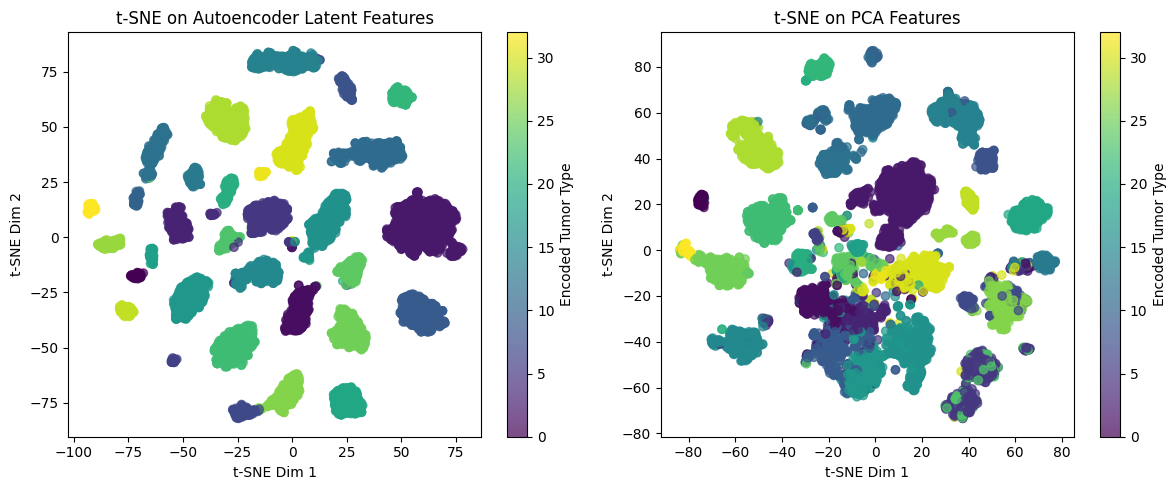

In [234]:
from sklearn.manifold import TSNE

tsne_random_state = 42

tsne_auto = TSNE(n_components=2, random_state=tsne_random_state)
X_auto_tsne = tsne_auto.fit_transform(X_train_latent)

tsne_pca = TSNE(n_components=2, random_state=tsne_random_state)
X_pca_tsne = tsne_pca.fit_transform(X_train_pca)

tumor_types_pca = label_encoder.inverse_transform(y_train)
tumor_types_autoenc = label_encoder.inverse_transform(y_train_auto)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_auto_tsne[:, 0], X_auto_tsne[:, 1], c=y_train_auto, cmap='viridis', alpha=0.7)
plt.title("t-SNE on Autoencoder Latent Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, label='Encoded Tumor Type')  

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title("t-SNE on PCA Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, label='Encoded Tumor Type')

plt.tight_layout()
plt.show()

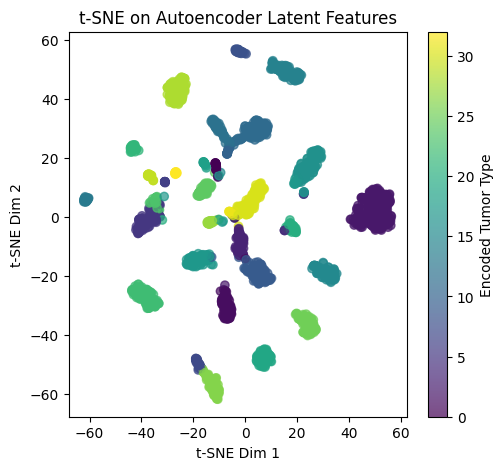

In [239]:
X_auto_tsne_test = tsne_auto.fit_transform(X_test_latent)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_auto_tsne_test[:, 0], X_auto_tsne_test[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
plt.title("t-SNE on Autoencoder Latent Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, label='Encoded Tumor Type')  

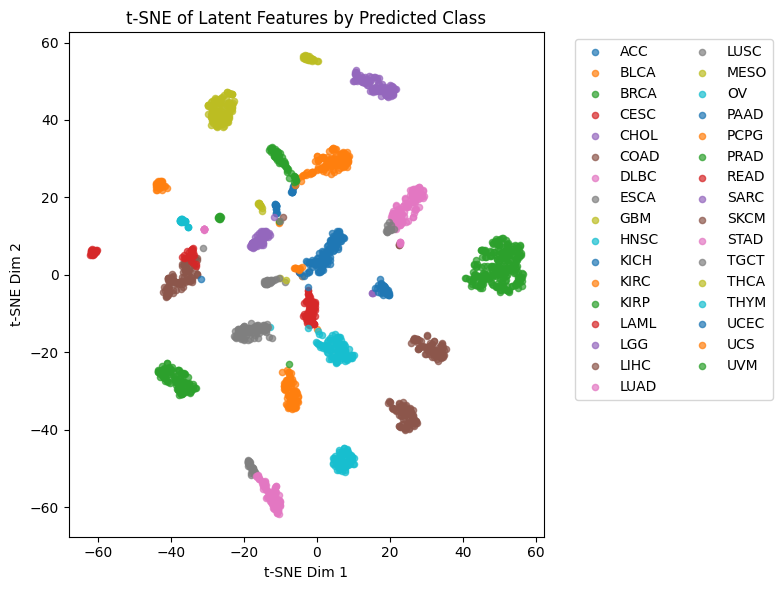

In [241]:
class_names = label_encoder.classes_
num_classes = 33

fig, ax = plt.subplots(figsize=(8,6))
for class_index in range(num_classes):
    mask = (y_pred == class_index)
    ax.scatter(
        X_auto_tsne_test[mask, 0],
        X_auto_tsne_test[mask, 1],
        s=20,
        label=class_names[class_index],
        alpha=0.7
    )

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.set_title("t-SNE of Latent Features by Predicted Class")
plt.tight_layout()
plt.show()

In [242]:
combined_latent = np.concatenate([X_train_latent, X_test_latent], axis=0)
combined_tsne = tsne_auto.fit_transform(combined_latent)

In [244]:
all_labels = np.concatenate([y_train_auto, y_pred], axis=0)  

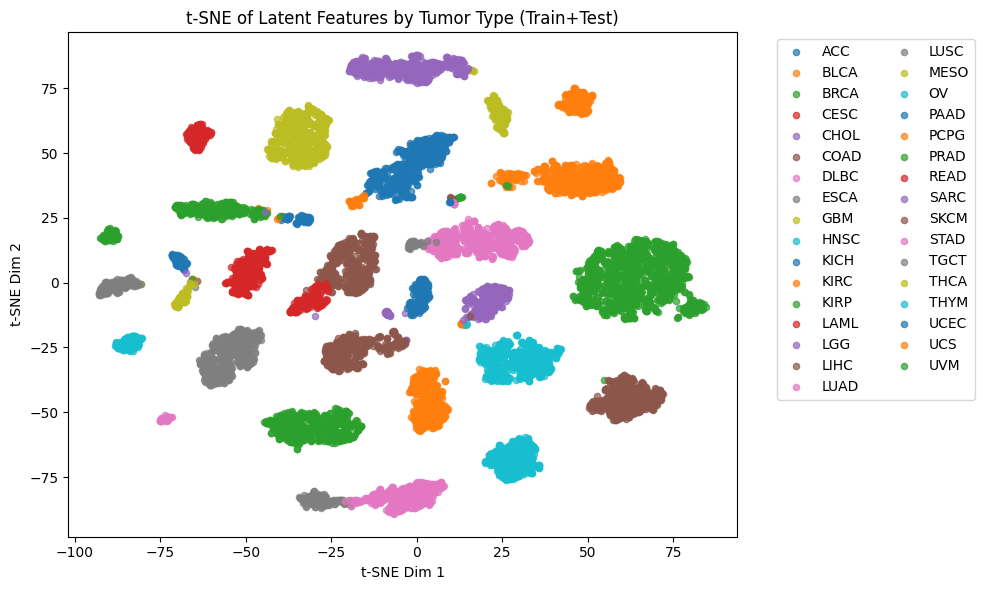

In [248]:
plt.figure(figsize=(10,6))
for class_index in range(num_classes):
    mask = (all_labels == class_index)   # boolean array of shape [N_total]
    plt.scatter(
        combined_tsne[mask, 0],
        combined_tsne[mask, 1],
        s=20,
        label=class_names[class_index],
        alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncols=2)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE of Latent Features by Tumor Type (Train+Test)")
plt.tight_layout()
plt.show()

In [60]:
import torch.nn as nn
import torch.nn.functional as F

class BranchingAutoencoder(nn.Module):
    def __init__(self, in_dim1, in_dim2, latent_dim=300, num_classes=33):
        super().__init__()
        
        self.in_dim1 = in_dim1
        self.in_dim2 = in_dim2
        
        # ENCODER BRANCH 1
        self.encoder1 = nn.Sequential(
            nn.Linear(in_dim1, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        # ENCODER BRANCH 2
        self.encoder2 = nn.Sequential(
            nn.Linear(in_dim2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        # Merge branches -> latent
        self.merge_fc = nn.Sequential(
            nn.Linear(256 + 256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.ReLU()
        )
        
        # DECODER
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, in_dim1 + in_dim2),
            nn.Sigmoid()  # data in [0,1]
        )
        
        # CLASSIFIER HEAD
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x1, x2):
        # Encode each subset
        e1 = self.encoder1(x1)
        e2 = self.encoder2(x2)
        # Merge
        merged = torch.cat([e1, e2], dim=1)
        latent = self.merge_fc(merged)
        
        # Decode
        reconstruction = self.decoder(latent)
        
        # Class logits
        logits = self.classifier(latent)
        
        return reconstruction, latent, logits


In [44]:
def joint_loss_function(reconstruction, x1, x2, logits, labels, alpha=1.0, beta=1.0):
    """
    reconstruction: (batch_size, in_dim1 + in_dim2)
    x1, x2: original inputs (batch_size, in_dim1 / in_dim2)
    logits: (batch_size, num_classes)
    labels: (batch_size,)
    alpha: weight for recon loss
    beta: weight for classification
    """
    bs = reconstruction.size(0)
    in_dim1 = x1.size(1)
    in_dim2 = x2.size(1)
    
    # Split recon back into 2 parts
    rec1 = reconstruction[:, :in_dim1]
    rec2 = reconstruction[:, in_dim1:in_dim1+in_dim2]
    
    # MSE reconstruction
    recon_loss1 = F.mse_loss(rec1, x1, reduction='mean')
    recon_loss2 = F.mse_loss(rec2, x2, reduction='mean')
    recon_loss = recon_loss1 + recon_loss2
    
    # Classification cross-entropy
    cls_loss = F.cross_entropy(logits, labels, reduction='mean', weight=weight_tensor)

    
    loss = alpha * recon_loss + beta * cls_loss
    return loss, recon_loss, cls_loss


In [73]:
N, input_dim = X.shape
in_dim1 = input_dim // 2
in_dim2 = input_dim - in_dim1

# Subset 1: First half of columns
X1 = X[:, :in_dim1]  
# also maybe other grouping techniques (by chromosome e.g.) worth trying
# Subset 2: Second half of columns
X2 = X[:, in_dim1:]  

In [74]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    X1, X2, y, test_size=0.2, random_state=42
)

X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(
    X1_train, X2_train, y_train, test_size=0.2, random_state=42
)

In [76]:
X1_train_tensor = torch.tensor(X1_train, dtype=torch.float32)
X2_train_tensor = torch.tensor(X2_train, dtype=torch.float32)
y_train_tensor  = torch.tensor(y_train, dtype=torch.long)

X1_val_tensor = torch.tensor(X1_val, dtype=torch.float32)
X2_val_tensor = torch.tensor(X2_val, dtype=torch.float32)
y_val_tensor  = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X1_train_tensor, X2_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X1_val_tensor,  X2_val_tensor,  y_val_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [77]:
X1_test_tensor = torch.tensor(X1_test, dtype=torch.float32)
X2_test_tensor = torch.tensor(X2_test, dtype=torch.float32)

In [78]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)
weights = 1.0 / class_counts
weights /= weights.sum()  # Normalize to sum to 1
weight_tensor = torch.tensor(weights, dtype=torch.float32)

In [79]:
model = BranchingAutoencoder(in_dim1, in_dim2, latent_dim=200, num_classes=33)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

alpha, beta = 1.0, 1.0
num_epochs = 50
patience = 10

best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss, train_recon, train_cls = 0.0, 0.0, 0.0
    
    for x1_batch, x2_batch, labels_batch in train_loader:
        x1_batch = x1_batch.float()
        x2_batch = x2_batch.float()
        labels_batch = labels_batch.long()
        
        optimizer.zero_grad()
        reconstruction, latent, logits = model(x1_batch, x2_batch)
        
        loss, recon_l, cls_l = joint_loss_function(
            reconstruction, x1_batch, x2_batch,
            logits, labels_batch,
            alpha=alpha, beta=beta
        )
        loss.backward()
        optimizer.step()
        
        batch_size = x1_batch.size(0)
        train_loss += loss.item() * batch_size
        train_recon += recon_l.item() * batch_size
        train_cls += cls_l.item() * batch_size
    
    # Average over total training samples
    n_train = len(train_loader.dataset)
    train_loss /= n_train
    train_recon /= n_train
    train_cls /= n_train
    
    # Validation
    model.eval()
    val_loss, val_recon, val_cls, correct, total = 0.0, 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for x1_valb, x2_valb, labels_valb in val_loader:
            x1_valb = x1_valb.float()
            x2_valb = x2_valb.float()
            labels_valb = labels_valb.long()
            
            reconstruction, latent, logits = model(x1_valb, x2_valb)
            loss, recon_l, cls_l = joint_loss_function(
                reconstruction, x1_valb, x2_valb,
                logits, labels_valb,
                alpha=alpha, beta=beta
            )
            
            val_loss += loss.item() * x1_valb.size(0)
            val_recon += recon_l.item() * x1_valb.size(0)
            val_cls += cls_l.item() * x1_valb.size(0)
            
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels_valb).sum().item()
            total += labels_valb.size(0)
    
    n_val = len(val_loader.dataset)
    val_loss /= n_val
    val_recon /= n_val
    val_cls /= n_val
    val_acc = correct / total
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} [Recon: {train_recon:.4f}, CLS: {train_cls:.4f}] | "
          f"Val Loss: {val_loss:.4f} [Recon: {val_recon:.4f}, CLS: {val_cls:.4f}] | "
          f"Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

# Load best model state
model.load_state_dict(best_model_state)

Epoch 1/50 | Train Loss: 1.9965 [Recon: 0.8020, CLS: 1.1945] | Val Loss: 1.0449 [Recon: 0.6610, CLS: 0.3839] | Val Acc: 0.8643
Epoch 2/50 | Train Loss: 1.1338 [Recon: 0.7293, CLS: 0.4046] | Val Loss: 1.0565 [Recon: 0.6851, CLS: 0.3714] | Val Acc: 0.8711
Epoch 3/50 | Train Loss: 0.9070 [Recon: 0.6325, CLS: 0.2745] | Val Loss: 1.2297 [Recon: 0.6076, CLS: 0.6221] | Val Acc: 0.8417
Epoch 4/50 | Train Loss: 0.8323 [Recon: 0.6085, CLS: 0.2238] | Val Loss: 0.9448 [Recon: 0.6127, CLS: 0.3321] | Val Acc: 0.9141
Epoch 5/50 | Train Loss: 0.8458 [Recon: 0.6037, CLS: 0.2421] | Val Loss: 0.9432 [Recon: 0.5969, CLS: 0.3464] | Val Acc: 0.8852
Epoch 6/50 | Train Loss: 0.7932 [Recon: 0.5998, CLS: 0.1934] | Val Loss: 1.0203 [Recon: 0.5969, CLS: 0.4234] | Val Acc: 0.8445
Epoch 7/50 | Train Loss: 0.7854 [Recon: 0.5978, CLS: 0.1876] | Val Loss: 0.9390 [Recon: 0.5948, CLS: 0.3442] | Val Acc: 0.9101
Epoch 8/50 | Train Loss: 0.7885 [Recon: 0.5971, CLS: 0.1914] | Val Loss: 0.9540 [Recon: 0.5942, CLS: 0.3598] | 

<All keys matched successfully>

In [28]:
torch.save(model.state_dict(), 'branching_autoencoder_weights.pth')

In [61]:
model = BranchingAutoencoder(in_dim1, in_dim2, latent_dim=300, num_classes=33)

model.load_state_dict(torch.load('branching_autoencoder.pth'))

<All keys matched successfully>

In [80]:
X1_full = np.concatenate([X1_train_tensor, X1_val_tensor])
X2_full = np.concatenate([X2_train_tensor, X2_val_tensor])
y_full = np.concatenate([y_train, y_val])

In [81]:
from imblearn.over_sampling import SMOTE

model.eval()
with torch.no_grad():
    # 1) Get latent for training set
    _, X_train_latent_tensor, _ = model(torch.tensor(X1_full), torch.tensor(X2_full))
    X_train_latent = X_train_latent_tensor.cpu().numpy()
    
    # 2) Get latent for test set
    _, X_test_latent_tensor, _ = model(X1_test_tensor, X2_test_tensor)
    X_test_latent = X_test_latent_tensor.cpu().numpy()

# Apply SMOTE to generate synthetic samples in latent space
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_latent_resampled, y_full_resampled = smote.fit_resample(X_train_latent, y_full)

# Train SVC on these latent training features
svm_clf = SVC(kernel="rbf", probability=True, random_state=42)
svm_clf.fit(X_train_latent_resampled, y_full_resampled)

# Predict on the test set latent
y_pred = svm_clf.predict(X_test_latent)

# Evaluate classification
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Test Accuracy: 0.9507
              precision    recall  f1-score   support

         ACC       1.00      1.00      1.00        20
        BLCA       0.93      0.93      0.93        94
        BRCA       1.00      0.98      0.99       238
        CESC       0.86      0.95      0.90        60
        CHOL       0.67      0.80      0.73         5
        COAD       0.89      0.83      0.86        96
        DLBC       0.93      1.00      0.96        13
        ESCA       0.83      0.83      0.83        24
         GBM       1.00      1.00      1.00        38
        HNSC       0.97      0.90      0.94       121
        KICH       0.75      0.95      0.84        19
        KIRC       0.98      0.92      0.95       129
        KIRP       0.91      0.92      0.92        65
        LAML       1.00      1.00      1.00        34
         LGG       1.00      1.00      1.00        99
        LIHC       0.97      0.96      0.96        94
        LUAD       0.91      0.94      0.93       106
     

In [ ]:
all_labels_names = label_encoder.inverse_transform(all_labels)
lusc_indices = np.where(all_labels_names == "LUSC")[0]
read_indices = np.where(all_labels_names == "READ")[0]

In [325]:
X_lusc = all_tsne[lusc_indices]
X_read = all_tsne[read_indices]


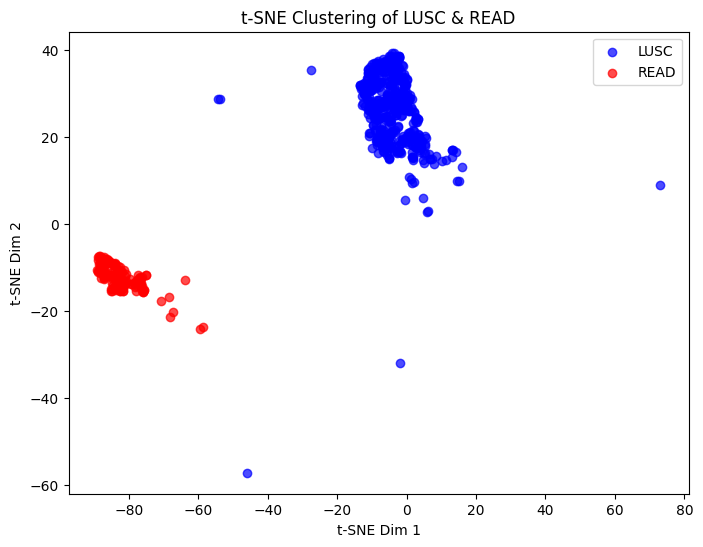

In [327]:
plt.figure(figsize=(8, 6))

plt.scatter(X_lusc[:, 0], X_lusc[:, 1], c='blue', label='LUSC', alpha=0.7)
plt.scatter(X_read[:, 0], X_read[:, 1], c='red', label='READ', alpha=0.7)

plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.title("t-SNE Clustering of LUSC & READ")

plt.show()


In [82]:
# Combine the features
all_latent = np.concatenate([X_train_latent_resampled, X_test_latent], axis=0)
# Combine the corresponding labels (y_train_auto + y_test)
all_labels = np.concatenate([y_full_resampled, y_test], axis=0)


In [83]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
all_tsne = tsne.fit_transform(all_latent)  # shape: (N_train+N_test, 2)


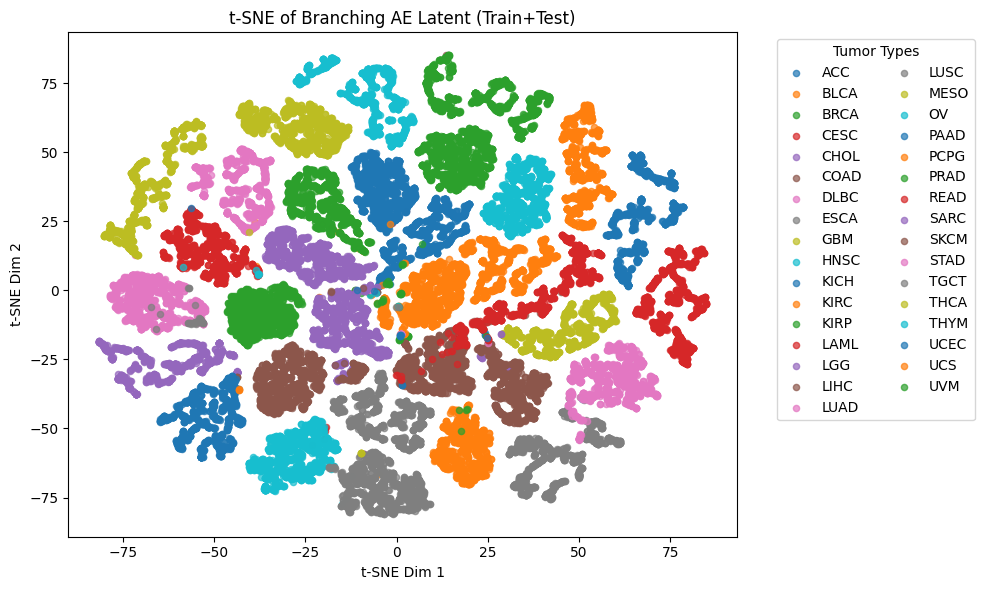

In [84]:
import matplotlib.pyplot as plt

class_names = label_encoder.classes_
num_classes = len(class_names)

plt.figure(figsize=(10, 6))

# Left subplot: AE Latent t-SNE
plt.title("t-SNE of Branching AE Latent (Train+Test)")
for class_index in range(num_classes):
    mask = (all_labels == class_index)
    plt.scatter(
        all_tsne[mask, 0],
        all_tsne[mask, 1],
        s=20,
        label=class_names[class_index],
        alpha=0.7
    )
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")

# Single legend for left plot
plt.legend(
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    ncol=2,
    title="Tumor Types"
)

plt.tight_layout()
plt.show()


In [310]:
np.random.seed(42)
background = X_train_latent[np.random.choice(X_train_latent.shape[0], size=50, replace=False)]

In [110]:
explainer = shap.KernelExplainer(model_predict, background)

In [111]:
X_test_sample = X_test_latent[:20]

shap_values = explainer.shap_values(X_test_sample)

  0%|          | 0/20 [00:00<?, ?it/s]

In [112]:
abs_shap = np.mean([np.abs(sv) for sv in shap_values], axis=0)  
global_shap_importance = np.mean(abs_shap, axis=0)  
print("Global SHAP importance for latent features:")
print(global_shap_importance)

Global SHAP importance for latent features:
[0.00079834 0.00233991 0.00321237 0.00123828 0.00020037 0.00143866
 0.00023764 0.0005818  0.00050194 0.00143595 0.00019169 0.00213132
 0.00078372 0.00039129 0.00188005 0.00063538 0.00145707 0.00185539
 0.00039396 0.00074886 0.00119985 0.00031998 0.00119965 0.00047859
 0.00140339 0.00215844 0.00120217 0.00096754 0.00163681 0.00045051
 0.00259011 0.00027209 0.00031205]


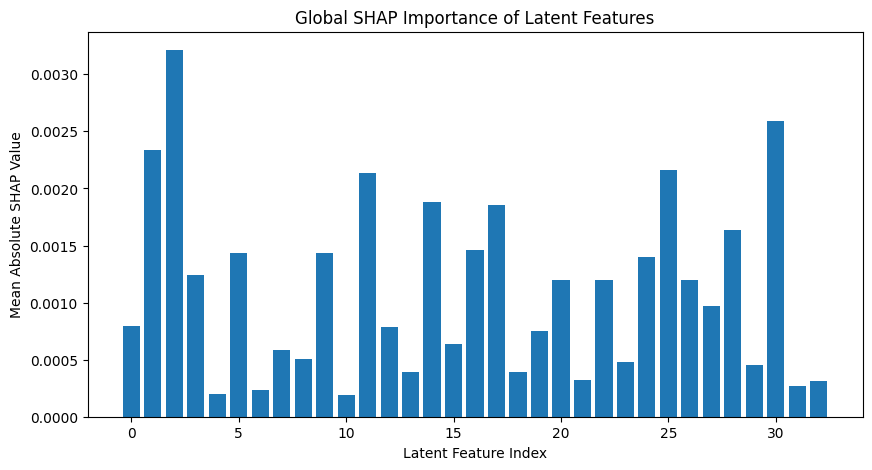

In [113]:
# Plot the global SHAP importance for latent features
plt.figure(figsize=(10, 5))
plt.bar(range(len(global_shap_importance)), global_shap_importance)
plt.xlabel("Latent Feature Index")
plt.ylabel("Mean Absolute SHAP Value")
plt.title("Global SHAP Importance of Latent Features")
plt.show()

In [118]:
y_pred = svm_clf.predict(X_test_latent)
df_expr = pd.DataFrame(X_test_scaled, columns=feature_cols)
df_expr['pred_class'] = y_pred

# Mean expression by predicted class
mean_expr_by_pred_class = df_expr.groupby('pred_class').mean()

# standard deviation across classes to see which genes vary the most
gene_variation = mean_expr_by_pred_class.std()
top_genes = gene_variation.sort_values(ascending=False).head(20)
top_genes_list = top_genes.reset_index().iloc[:, 0].tolist()

In [184]:
translated_genes = [combined_gene_name_map.get(gene_id, gene_id) for gene_id in top_genes_list]

In [189]:
translated_genes

['RAB25',
 'GRHL2',
 'ESRP1',
 'PRSS8',
 'AP1M2',
 'LINC02967',
 'ELF3',
 'CLDN4',
 'PKP3',
 'GPX2',
 'KRT5',
 'EHF',
 'LAD1',
 'CBLC',
 'S100A14',
 'MIR200CHG',
 'GJB1',
 'TMPRSS4',
 'FXYD3',
 'KDF1']